# Math Magik LPP Design notes

In this note, we will work through the development of Python code needed to generate the film covering we will use on the *math-magik-lpp* model. This model is using a simple circular arc airfoil, so let's begin by looking at the basic geometry of that airfoil.

We will use the LaTeX *tikz* package to generate these figures. *Jupyter* can generate these images using the Python *itikz* package.

In [1]:
%load_ext itikz

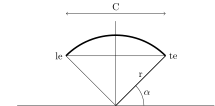

In [2]:
%%itikz

\documentclass{standalone}
\usepackage{tikz}
\begin{document}
\usetikzlibrary{calc}
\begin{tikzpicture}
  \draw(0,0) -- (7,0);
  \draw[thick](3.5,0) -> node[above] {r} ++(45:2.5) coordinate (p1);
  \draw(3.5,0) -- ++(135:2.5) coordinate (p2);
  \draw(3.5,0) -- (3.5,3);
  \draw[ultra thick] (p1) arc (45:135:2.5);
  \draw (4.5,0) arc (0:45:1);
  \draw (p1) -- (p2);
  \node[right] at (p1) {te};
  \node[left] at (p2) {le};
  \coordinate (angle_label) at ($ (3.5,0) + (22.5:1.2) $);
  \node at (angle_label) {$\alpha$};
  \coordinate (p3) at ($(p1) + (0,1.5) $);
  \coordinate (p4) at ($ (p2) + (0,1.5) $);
  \draw[<->] (p3) -- node[above] {C} (p4);
\end{tikzpicture}
\end{document}

From this figure, we can generate equations for the thickness and angle $\alpha$.

$$
t = r -r sin(\alpha)
$$

$$
C = 2 r cos(\alpha)
$$


We are usually given the chord and the *camber* as a percentage of the chord. Our problem is now figuring out the equations for the thickness $t$ and $\alpha$ ! Let's use the Python *sympy* package to solve this problem.

In [5]:
import sympy
sympy.init_printing(use_latex='mathjax')

In [6]:
r,c,t,alpha = \
  sympy.symbols('r c t alpha')

eq1 = 2 * r * sympy.cos(alpha) - c
eq2 = r - r * sympy.sin(alpha) - t
sol = sympy.solve([eq1,eq2],[r,alpha])

In [7]:
print(sol)

[(c**2/(8*t) + t/2, -acos(4*c*t/(c**2 + 4*t**2)) + 2*pi), (c**2/(8*t) + t/2, acos(4*c*t/(c**2 + 4*t**2)))]


There are two angles that satisfy these equations, so we need to extract the correct one we will use.  Here are the results we need.

The radius of the airfoil is given by this equation:

In [8]:
display(sol[1][0])

  2    
 c    t
─── + ─
8⋅t   2

The angle $\alpha$ (in *radians*) is given by this equation:

In [9]:
display(sol[1][1])

    ⎛  4⋅c⋅t  ⎞
acos⎜─────────⎟
    ⎜ 2      2⎟
    ⎝c  + 4⋅t ⎠

As a check, let's try an example for a chord of five inches, and a camber of five percent.

In [10]:
import math

c = 5;
camber = 5;
t = camber * c/100
r = c**2/(8*t) + t/2
alpha  =  math.acos(4*c*t/(c**2 + 4*t**2)) * 180/math.pi
print(r, alpha)

12.625 78.57881372500071


As a check, let's calculate the thickness using these values:

In [11]:
thickness = r - r * math.sin(alpha*math.pi/180)
print(thickness)

0.25


That looks correct!

## Generating the Airfoil Height

We will also need a way to figure out the height of the airfoil at some location along that airfoil axis. We can use the equation for a circle to set this up. 

In [12]:
x, y, h, w, r, c, t, beta = sympy.symbols('x y h w r c t beta')

In [13]:
eq3 =(x - w)**2 + (y - h)**2 - r**2
display(eq3)

   2           2           2
- r  + (-h + y)  + (-w + x) 

In [14]:
eq4 = sympy.solve(eq3,y)
display(eq4)

⎡      _________________________        _________________________⎤
⎣h - ╲╱ (r - w + x)⋅(r + w - x) , h + ╲╱ (r - w + x)⋅(r + w - x) ⎦

In [15]:
eq5 = eq4[1]
eq6 = eq5.subs(w,c/2)
display(eq6)

        ___________________________
       ╱ ⎛  c        ⎞ ⎛c        ⎞ 
h +   ╱  ⎜- ─ + r + x⎟⋅⎜─ + r - x⎟ 
    ╲╱   ⎝  2        ⎠ ⎝2        ⎠ 

In [16]:
eq7 = eq6.subs(h,t-r)
display(eq7)

             ___________________________
            ╱ ⎛  c        ⎞ ⎛c        ⎞ 
-r + t +   ╱  ⎜- ─ + r + x⎟⋅⎜─ + r - x⎟ 
         ╲╱   ⎝  2        ⎠ ⎝2        ⎠ 

In [17]:
print(eq7)

-r + t + sqrt((-c/2 + r + x)*(c/2 + r - x))


That is a bit messy, but Python will not care. 

Again, we need to test this equation. Lets set up a function that returns the height for some value of $x$ ranging from 0 to 1. (This will be some fraction of the chord).

In [18]:
def height(x):
    r = 12.625
    t = 0.25
    c = 5
    x = x * c
    return -r + t + math.sqrt((-c/2 + r + x)*(c/2 + r - x))

Now we can try this for several values of $X$:

In [19]:
dx = 0.1
xc = 0.0
for n in range(11):
    print(height(xc))
    xc = xc + dx

0.0
0.0905776039459969
0.1605743785436502
0.21033372620686563
0.2400951244927203
0.25
0.2400951244927203
0.21033372620686563
0.1605743785436502
0.0905776039459969
0.0


That looks exactly like it is supposed to look!


## Wing Outline

We still have some work to do. To use this function properly, we need to generalize it so we can feed it dirrerent chord and camber values. Then we need to generate functions that give us the $x_{le}$ and $x_{te}$ values for the wing for some position $y$. For this design, we will use a constant camber across the center section, and use a linear taper from the edge of the center section to the wing tips. 

Let's. generalize the height function first. This requires combining equations we have presented earlier.

In [20]:
def wing_height(chord, camber, x):
    t = camber * chord/100
    r = chord**2/(8*t) + t/2
    x = chord * x
    return -r + t + math.sqrt((-chord/2 + r + x)*(chord/2 + r - x))

In [21]:
print(wing_height(5.0,5.0,0.5))

0.25


The leading edge runs along the $y$ axis until we reach the point wher the circluar tip is located. We need to span and the tip radius to calculate the offset. Again the equation for a circle gives us the required equation.

In [22]:
x, y, s, r = sympy.symbols('x y s r')

In [23]:
eq7 = (x -r)**2 + y**2 - r**2

In [24]:
sol3 = sympy.solve(eq7, x)

In [25]:
display(sol3)

⎡      _________________        _________________⎤
⎣r - ╲╱ (r - y)⋅(r + y) , r + ╲╱ (r - y)⋅(r + y) ⎦

The first solution is the one we need.

In [26]:
def xle(s,r,y):
    """s is the half span, r is the tip radius, Y ranges from -1 to +1"""
    y = y * s
    if abs(y) < s - r:
        return 0.0
    yt = abs(y) - (s - r)
    return r - math.sqrt((r - yt) *(r + yt))

In [27]:
print(xle(9.0,2.0,1.0))

2.0


In [28]:
def xte(chord, y):
    return chord

Now, let's build a function that returns the local camber. This will be constant until we reach the tip, then taper linearly to zero at the tip.

In [29]:
def camber_y(s, yt, c, y):
    """S is the half span, yt is the tip location, c is the base camber, and y ranges from -1 to +1"""
    y = abs(y) * s
    if y < yt:
       return c
    taper = 1.0 - (y - yt) / (s - yt)
    return taper * c

In [30]:
print(camber_y(9, 6, 5.0, -6/9))

5.0


We now have the pieces to generate the covering matrix needed bu OpenSCAD.

In [31]:
def gen_covering(span, chord, camber, yt, rtip, nx, ny):
    """
    span is the half wingspan
    chord is the root chord width
    yt is the start of the tip
    rtip is the tip radius
    nx and ny are the sizes of the matrix
    """
    dy = 1.0 / ny
    y = 0.0
    for i in range(ny + 1):
        x0 = xle(span, rtip, y)
        x1 = xte(chord, y)
        local_chord = x1 - x0
        local_camber = camber_y(span,yt,camber,y)
        x = 0.0
        for j in range(nx + 1):
            h = wing_height(local_chord, local_camber, x)
            lx = x0 + x * local_chord
            ly = y * span
            g_pt = "[{0:.2f}, {1:.2f}, {2:.2f}]".format(lx, ly, h)
            print(g_pt)
            x = x + dx
            if x > 1.0: x = 1.0
        y = y + dy
        if y > 1.0: y = 1.0

In [32]:
gen_covering(9,5,5,6,2,10,10)

[0.00, 0.00, 0.00]
[0.50, 0.00, 0.09]
[1.00, 0.00, 0.16]
[1.50, 0.00, 0.21]
[2.00, 0.00, 0.24]
[2.50, 0.00, 0.25]
[3.00, 0.00, 0.24]
[3.50, 0.00, 0.21]
[4.00, 0.00, 0.16]
[4.50, 0.00, 0.09]
[5.00, 0.00, 0.00]
[0.00, 0.90, 0.00]
[0.50, 0.90, 0.09]
[1.00, 0.90, 0.16]
[1.50, 0.90, 0.21]
[2.00, 0.90, 0.24]
[2.50, 0.90, 0.25]
[3.00, 0.90, 0.24]
[3.50, 0.90, 0.21]
[4.00, 0.90, 0.16]
[4.50, 0.90, 0.09]
[5.00, 0.90, 0.00]
[0.00, 1.80, 0.00]
[0.50, 1.80, 0.09]
[1.00, 1.80, 0.16]
[1.50, 1.80, 0.21]
[2.00, 1.80, 0.24]
[2.50, 1.80, 0.25]
[3.00, 1.80, 0.24]
[3.50, 1.80, 0.21]
[4.00, 1.80, 0.16]
[4.50, 1.80, 0.09]
[5.00, 1.80, 0.00]
[0.00, 2.70, 0.00]
[0.50, 2.70, 0.09]
[1.00, 2.70, 0.16]
[1.50, 2.70, 0.21]
[2.00, 2.70, 0.24]
[2.50, 2.70, 0.25]
[3.00, 2.70, 0.24]
[3.50, 2.70, 0.21]
[4.00, 2.70, 0.16]
[4.50, 2.70, 0.09]
[5.00, 2.70, 0.00]
[0.00, 3.60, 0.00]
[0.50, 3.60, 0.09]
[1.00, 3.60, 0.16]
[1.50, 3.60, 0.21]
[2.00, 3.60, 0.24]
[2.50, 3.60, 0.25]
[3.00, 3.60, 0.24]
[3.50, 3.60, 0.21]
[4.00, 3.60,

## Calculate Tip Span

The class rules limit the projected wing span. We need to specify the center span, and the tip height, then calculate the actual tip span.

In [33]:
max_span = 9
center_span = 6
tip_height = 1.75
tip_span = math.sqrt(tip_height**2 + (max_span - center_span)**2)
print(tip_span)

3.473110997362451


There is one more wrinkle in this setup.

When we create the final win, the tip will be angled up to create the dihedral. The rib at the end of the center section will be vertical, so the actual camber at the start of the tip will not be correct if we make it the same as the center section camber. We need a picture to show this issue.

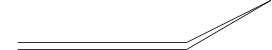

In [42]:
%%itikz

\documentclass{standalone}
\usepackage{tikz}
\begin{document}
\usetikzlibrary{calc}
\begin{tikzpicture}
  \draw[thick] (0,0) -- (6,0) -- (9,1.75);
  \draw[thick] (0,0.25) -- (6,0.25) -- (9,1.75);
\end{tikzpicture}
\end{document}

The issue is figuring out what the camber should be for the tip at the dihedral break. We will be generating this covering, then slice off the part that would be inside the center section. (Is the intersection going to be correct? We need to test this to make sure.)

A "perfect joint between two cylinders with the same radius would happen along a plane that cuts through both cylinders in such a way that both cylinders are cut in an identical angle. If the dihedral joint lifted the tip at 30 degrees, the plane should cut both parts at 15 degrees. Here is a figure (generated using OpenSCAD) showing an example joint:

![Example Joint](tip-joint.png)

From this figure, you should see that cutting the tip section using a vertical plane would result in a joint that is too high on the tip side. If we are going to keep the center section "square", we need to figure out a new curve at the tip joint. Since the rib is constructed on the center section, we need to construct a properly trimmed floating cover edge for the tip.

In generating the point matrix for the center section, we will have a set of points anong the edge. We need to *transform* these points into the tip coordinate syetem (aligned with the tip frame. And use that as the starting point for the covering grid on the tip. We are assuming a linear change in camber alomg the tip, so we can simple draw a straignt line from the center section edge to the final ip points. For simplicity, the last rib in the tip is just a straight piece.

We will generate the covering grid using a fixed number of points, evenly spaced along the chord line for every *Y* station we select. This will produce a grid acceptable for submitting to the `Justin Lin`_ *function grapher* code. To calculate the covering point grid for the tip, we need to figureout the equation for these straight line segments

## Lines in 3D Space

Given two points in a 3D space:
$$
p1 = (x1,y1,z1)
$$

$$
p2 = (x2,y2,z2)
$$

We need to come up with equations we can use to find covering points along the line between these two points.

Define three more constants:
$$    
l = (x2 - x1)
$$

$$
m = (y2 - y1)
$$

$$
n = (z2 - z1)
$$

Then these equations apply:
    
$$
\frac{x - x1}{l} = \frac{y - y1}{m} = \frac{z - z1}{n}
$$

With these equations, we can generate the grid as follows:
                                                        
1. set the $y$ value
2. calculate $x$ using that value of $y$
3. calculate $z$ from the value of $y$

The only remaining puzzle is figuring out the transformation of the outer center section rib points into the tip coordinate system. This system is a simple rotation around the *X* axis, so this is not so bad to figure out.

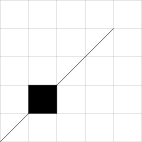

In [50]:
%%itikz
\documentclass[tikz]{standalone}
\begin{document}
\begin{tikzpicture}
\draw[help lines] grid (5, 5);
\draw[fill=black] (1, 1) rectangle (2, 2);
\draw (0,0) -- (4,4);
\end{tikzpicture}
\end{document}


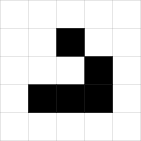

In [45]:
%%itikz
\documentclass[tikz]{standalone}
\begin{document}
\begin{tikzpicture}
\draw[help lines] grid (5, 5);
\draw[fill=black] (1, 1) rectangle (2, 2);
\draw[fill=black] (2, 1) rectangle (3, 2);
\draw[fill=black] (3, 1) rectangle (4, 2);
\draw[fill=black] (3, 2) rectangle (4, 3);
\draw[fill=black] (2, 3) rectangle (3, 4);
\end{tikzpicture}
\end{document}